<a href="https://colab.research.google.com/github/revygabor/HF4/blob/master/HF4_train_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier training

Classifier trainer script for the 4th homework. I used the Xception feature extractor for classifying cats and horses.
I recommend running it on Google Colab.

In [0]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
from google.colab import files

files.upload() # upload the 2 files with the urls

In [0]:
class1_image_urls = np.load('cat_urls.npy') # loading in the urls
class2_image_urls = np.load('horse_urls.npy')

In [3]:
from PIL import Image
import sys
from keras.applications.xception import Xception, preprocess_input

Using TensorFlow backend.


In [0]:
def download_images(urls, name):

  n_dataset = 600 # number of pictures to download

  images = np.empty((0,299,299,3)) # we store the images here
  i = 0
  n_images = 0
  while n_images<n_dataset:
    try:
      site = urlopen(urls[i]) # open the site with the image
      image = Image.open(site).resize((299, 299), Image.BICUBIC) # loading in the image and resizing for xception
      image = np.array(image) # convert it to numpy array
      assert image.shape == (299, 299, 3) # if the shape is not acceptable we throw it out and go to the next image 
    except:
      i+=1
      continue
    
    image = preprocess_input(image) # preprocess it for the xception
    images = np.concatenate((images, image[None, :])) # add it to the other preprocessed images
    sys.stdout.write("\r{}".format(n_images)) # number of preprocessed images
    sys.stdout.flush()
    i+=1
    n_images += 1

  return images

In [5]:
class1_name = 'cat'
class2_name = 'horse'

class1_images = download_images(class1_image_urls, class1_name) # we download the images from the sites with the downloaded urls
class2_images = download_images(class2_image_urls, class2_name)

599

In [7]:
print('{} data shape: {}'.format(class1_name, class1_images.shape))
print('{} data shape: {}'.format(class2_name, class2_images.shape))

cat data shape: (600, 299, 299, 3)
horse data shape: (600, 299, 299, 3)


In [0]:
class1_y = np.zeros((600, 2)) # create labels for cat images [1, 0]
class1_y[:, 0] = 1

class2_y = np.zeros((600, 2)) # create labels for cat images [0, 1]
class2_y[:, 1] = 1

In [0]:
x_train = np.concatenate((class1_images[:400], class2_images[:400])) # train split; half of the images is from class1, other half is from class2
y_train = np.concatenate((class1_y[:400], class2_y[:400]))

x_val = np.concatenate((class1_images[400:500], class2_images[400:500])) # validation split
y_val = np.concatenate((class1_y[400:500], class2_y[400:500]))

x_test = np.concatenate((class1_images[500:600], class2_images[500:600])) # test split
y_test = np.concatenate((class1_y[500:600], class2_y[500:600]))

In [0]:
shuffle_index = np.random.permutation(800) # shuffle train data
x_train = x_train[shuffle_index]
y_train = y_train[shuffle_index]

shuffle_index = np.random.permutation(200) # shuffle validation data
x_val = x_val[shuffle_index]
y_val = y_val[shuffle_index]

shuffle_index = np.random.permutation(200) # shuffle test data
x_test = x_test[shuffle_index]
y_test = y_test[shuffle_index]

In [0]:
from keras.layers import Input, Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model

In [48]:
input_tensor = Input(shape=(299, 299, 3)) # create the input layer: 299x299 RGB
base_model = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False) # download the pretrained xception model
x = base_model.output
x = Flatten()(x) # flatten the output of the feature extractor
predictions = Dense(2, activation='softmax')(x) # predict 2 values: class1, class2

model = Model(inputs=input_tensor, outputs=predictions) # create model

for l in base_model.layers: # freeze the layers in the xception model
  l.trainable = False

optimizer = Adam() # use the Adam optimizer
checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True) # save the model if it improves
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True) # if the model doesn't improve stop training
# this callback also restores the best saved weights at the end of the training


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # we use categorical crossentropy loss
model.summary() # print model layers

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [49]:
model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val), callbacks=[checkpointer, early_stopping])

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 681s 851ms/step - loss: 1.2246 - acc: 0.8787 - val_loss: 0.3239 - val_acc: 0.9700

Epoch 00001: val_loss improved from inf to 0.32391, saving model to model
Epoch 2/10
800/800 [==============================] - 692s 865ms/step - loss: 0.7435 - acc: 0.9450 - val_loss: 1.1662 - val_acc: 0.9150

Epoch 00002: val_loss did not improve from 0.32391
Epoch 3/10
800/800 [==============================] - 694s 867ms/step - loss: 0.5226 - acc: 0.9562 - val_loss: 0.2674 - val_acc: 0.9700

Epoch 00003: val_loss improved from 0.32391 to 0.26740, saving model to model
Epoch 4/10
800/800 [==============================] - 721s 902ms/step - loss: 0.5290 - acc: 0.9562 - val_loss: 0.2351 - val_acc: 0.9750

Epoch 00004: val_loss improved from 0.26740 to 0.23506, saving model to model
Epoch 5/10
800/800 [==============================] - 695s 869ms/step - loss: 0.1933 - acc: 0.9813 - val_loss: 0.8358 - val_a

In [51]:
for l in model.layers[-18:]: # unfreeze the last layers of the model
  l.trainable = True

  
optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.2, nesterov=True) # we use SGD for finer optimization
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val), callbacks=[checkpointer, early_stopping])

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 832s 1s/step - loss: 0.1496 - acc: 0.9875 - val_loss: 0.5703 - val_acc: 0.9600

Epoch 00001: val_loss did not improve from 0.13831
Epoch 2/10
800/800 [==============================] - 822s 1s/step - loss: 0.3013 - acc: 0.9800 - val_loss: 0.6117 - val_acc: 0.9600

Epoch 00002: val_loss did not improve from 0.13831
Epoch 3/10
800/800 [==============================] - 830s 1s/step - loss: 0.0882 - acc: 0.9925 - val_loss: 0.4225 - val_acc: 0.9500

Epoch 00003: val_loss did not improve from 0.13831
Epoch 4/10
800/800 [==============================] - 836s 1s/step - loss: 0.2516 - acc: 0.9813 - val_loss: 0.6475 - val_acc: 0.9500

Epoch 00004: val_loss did not improve from 0.13831
Epoch 5/10
800/800 [==============================] - 835s 1s/step - loss: 0.1411 - acc: 0.9875 - val_loss: 0.3377 - val_acc: 0.9700

Epoch 00005: val_loss did not improve from 0.13831
Epoch 6/10
800/800 [=========

In [54]:
res = model.evaluate(x_test, y_test, batch_size=16) # evaluate on test data

200/200 [==============================] - 151s 756ms/step


In [55]:
print('loss: {}, accuracy: {}'.format(res[0], res[1]))

loss: 0.48204332991969406, accuracy: 0.965


In [0]:
preds = model.predict(x_test[20:30]) # make predictions

In [0]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 229, 229

predicted: cat, label: cat
predicted: cat, label: cat
predicted: cat, label: cat
predicted: horse, label: horse
predicted: horse, label: horse
predicted: horse, label: horse
predicted: horse, label: horse
predicted: cat, label: cat
predicted: cat, label: cat
predicted: horse, label: horse


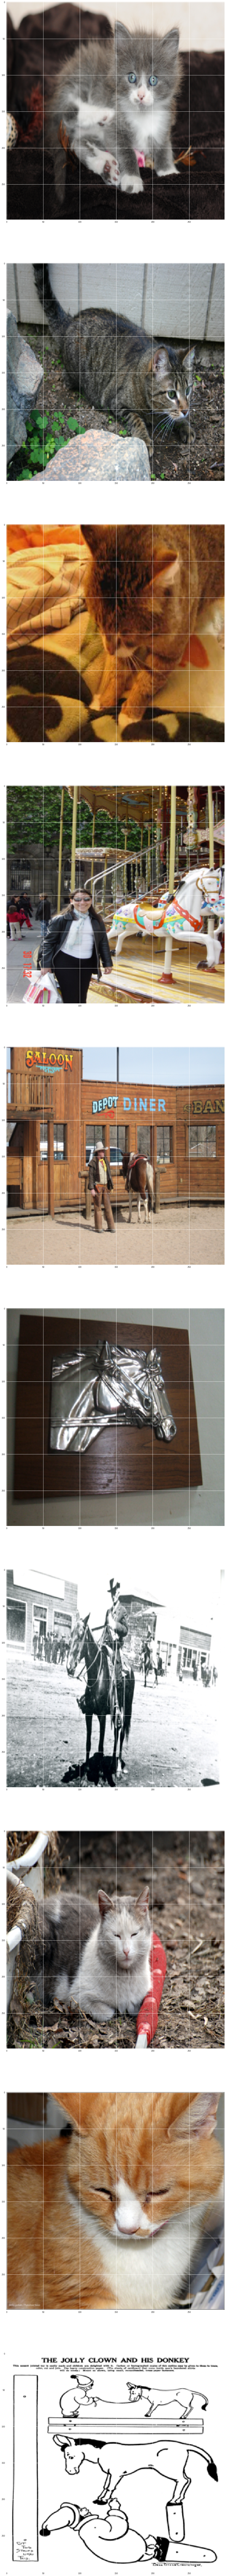

In [91]:
preds = np.argmax(preds, axis=1) # convert predictions to class IDs
labels = np.argmax(y_test[20:30], axis=1) # convert labels to class IDs

fig, axes = plt.subplots(10) # creating matplotlib figure


for i in range(10):
  axes[i].imshow((x_test[i+20]+1)/2) # we have to transform back the image
  print('predicted: {}, label: {}'.format('cat' if preds[i]==0 else 'horse', 'cat' if labels[i]==0 else 'horse' )) # printing predicted and ground truth labels